In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, precision_recall_curve, roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

from termcolor import colored

In [267]:
# Function for examining scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [268]:
df = pd.read_csv("../Heart_Failure_Prediction/Heart_Failure.csv")

In [269]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [270]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [271]:
for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} posiada {df[col].nunique()} unikalnych wartości")

Age posiada 50 unikalnych wartości
RestingBP posiada 67 unikalnych wartości
Cholesterol posiada 222 unikalnych wartości
FastingBS posiada 2 unikalnych wartości
MaxHR posiada 119 unikalnych wartości
Oldpeak posiada 53 unikalnych wartości
HeartDisease posiada 2 unikalnych wartości


In [272]:
df.duplicated().value_counts()

False    918
dtype: int64

Podział na dane numeryczne i kategoryczne

In [273]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'kolumny numeryczne:  {df[numerical].columns}')
print(f'kolumny kategoryczne:: {df[categorical].columns}')

kolumny numeryczne:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')
kolumny kategoryczne:: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


Dane numeryczne

In [274]:
df[numerical].head().T

,0,1,2,3,4
Age,40.0,49.0,37.0,48.0,54.0
RestingBP,140.0,160.0,130.0,138.0,150.0
Cholesterol,289.0,180.0,283.0,214.0,195.0
FastingBS,0.0,0.0,0.0,0.0,0.0
MaxHR,172.0,156.0,98.0,108.0,122.0
Oldpeak,0.0,1.0,0.0,1.5,0.0


In [275]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [276]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [277]:
df[numerical].iplot(kind='histogram', subplots=True,bins=50)

Dane kategoryczne

In [278]:
df[categorical].head().T

,0,1,2,3,4
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingECG,Normal,Normal,ST,Normal,Normal
ExerciseAngina,N,N,N,Y,N
ST_Slope,Up,Flat,Up,Flat,Up


In [279]:
df[categorical].describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [280]:
df[categorical].iplot(kind='hist');

In [281]:
df[categorical].iplot(kind='histogram',subplots=True,bins=50)

Podział zbioru na treningowy i testowy

In [282]:
df[categorical].value_counts()
df = pd.get_dummies(df, drop_first=True)

In [283]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]
scaler = MinMaxScaler()
scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)

Feature Scaling

XGBoost

XG Boost - dafault

In [284]:
XGB_model = XGBClassifier(random_state=101)
XGB_model.fit(X_train_scaled, y_train)
y_pred = XGB_model.predict(X_test_scaled)
y_train_pred = XGB_model.predict(X_train_scaled)

xgb_f1 = f1_score(y_test, y_pred)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

train_val(y_train, y_train_pred, y_test, y_pred)

[[55  7]
 [ 9 67]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        62
           1       0.91      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.0,0.884058
Precision,1.0,0.905405
Recall,1.0,0.881579
f1,1.0,0.893333


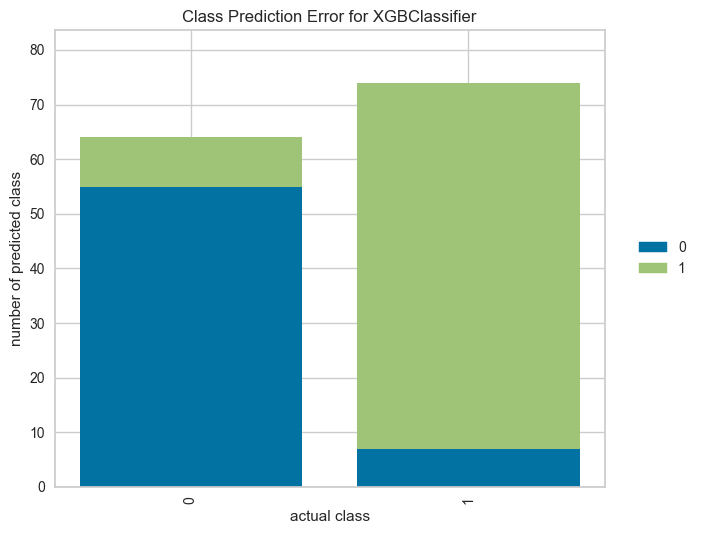

In [285]:
from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(XGB_model)
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.poof();

XGboost - walidacja krzyżowa

In [286]:
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.129149,0.016046,0.820513,0.837209,0.837209,0.837209
2,0.118059,0.016028,0.756410,0.772727,0.790698,0.781609
3,0.120262,0.015524,0.897436,0.888889,0.930233,0.909091
4,0.104747,0.014995,0.846154,0.860465,0.860465,0.860465
5,0.107626,0.015532,0.846154,0.878049,0.837209,0.857143
6,0.100817,0.017049,0.884615,0.854167,0.953488,0.901099
7,0.113638,0.016048,0.846154,0.816327,0.930233,0.869565
8,0.117989,0.015170,0.820513,0.837209,0.837209,0.837209
9,0.126290,0.019058,0.807692,0.871795,0.772727,0.819277
10,0.144876,0.012083,0.897436,0.891304,0.931818,0.911111


In [287]:
xgb_xvalid_model_scores.mean()

fit_time          0.118345
score_time        0.015753
test_accuracy     0.842308
test_precision    0.850814
test_recall       0.868129
test_f1           0.858378
dtype: float64

In [288]:
XGB_model.feature_importances_ 

array([0.01034658, 0.00827132, 0.01459766, 0.02276584, 0.01219854,
       0.01343196, 0.020674  , 0.01842575, 0.02250192, 0.01536593,
       0.01140481, 0.01122345, 0.03192241, 0.01766846, 0.76920134],
      dtype=float32)

In [289]:
feats = pd.DataFrame(index=X.columns, data=XGB_model.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

XGB_feature_imp 

,Feature Importance
ST_Slope_Up,0.769201
ExerciseAngina_Y,0.031922
FastingBS,0.022766
ChestPainType_NAP,0.022502
Sex_M,0.020674
ChestPainType_ATA,0.018426
ST_Slope_Flat,0.017668
ChestPainType_TA,0.015366
Cholesterol,0.014598
Oldpeak,0.013432


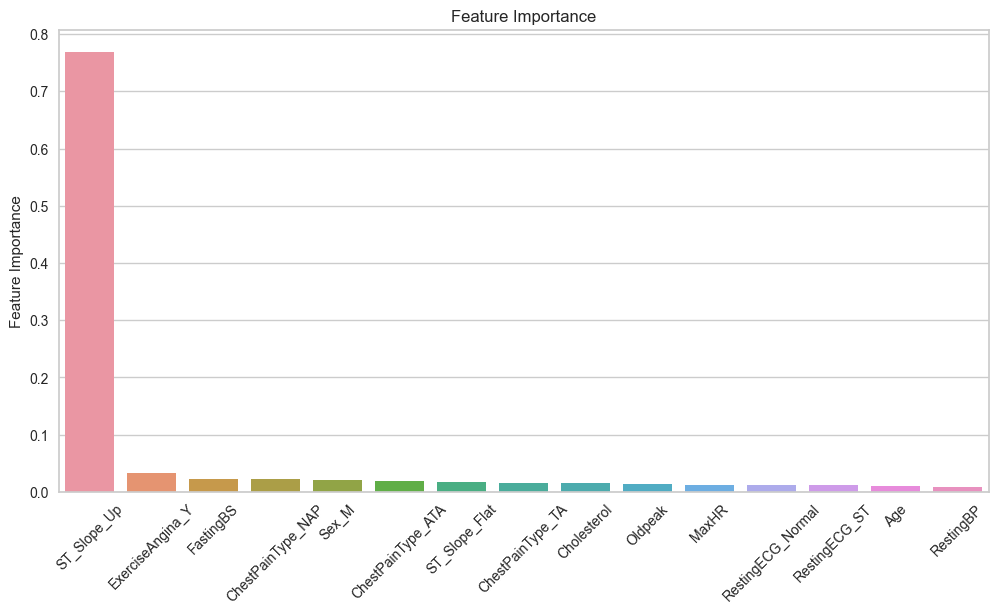

In [290]:
plt.figure(figsize=(12,6))
sns.barplot(y=XGB_feature_imp["Feature Importance"], x=XGB_feature_imp.index)
plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

Usuwamy ST_Slope_UP żeby sprawdzić jaki ma to wpływ na wynik

In [291]:
X2 = X.drop(columns = ["ST_Slope_Up"]) 
X2.columns
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X2, y, test_size=0.15, stratify = y, random_state = 101)

In [292]:
operations = [("scaler", MinMaxScaler()), ("xgb", XGBClassifier(random_state=101))]

XGB_pipe_model = Pipeline(steps=operations)
XGB_pipe_model.get_params()
XGB_pipe_model.fit(X_train, y_train)

y_pred = XGB_pipe_model.predict(X_test)
y_train_pred = XGB_pipe_model.predict(X_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

xgb_pipe_f1 = f1_score(y_test, y_pred)
xgb_pipe_acc = accuracy_score(y_test, y_pred)
xgb_pipe_recall = recall_score(y_test, y_pred)
xgb_pipe_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

train_val(y_train, y_train_pred, y_test, y_pred)

[[56  6]
 [ 8 68]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        62
           1       0.92      0.89      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

[[56  6]
 [ 8 68]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        62
           1       0.92      0.89      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.0,0.898551
Precision,1.0,0.918919
Recall,1.0,0.894737
f1,1.0,0.906667


In [293]:
pipe_scores = cross_validate(XGB_pipe_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))
df_pipe_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.096906,0.015049,0.820513,0.822222,0.860465,0.840909
2,0.117832,0.015546,0.794872,0.800000,0.837209,0.818182
3,0.099745,0.017046,0.923077,0.893617,0.976744,0.933333
4,0.108298,0.014523,0.858974,0.880952,0.860465,0.870588
5,0.117193,0.017541,0.820513,0.871795,0.790698,0.829268
6,0.109265,0.016532,0.871795,0.851064,0.930233,0.888889
7,0.112305,0.017040,0.871795,0.836735,0.953488,0.891304
8,0.094974,0.017542,0.794872,0.829268,0.790698,0.809524
9,0.100830,0.016531,0.846154,0.921053,0.795455,0.853659
10,0.101863,0.015054,0.897436,0.909091,0.909091,0.909091


In [294]:
df_pipe_scores.mean()[2:]

test_accuracy     0.850000
test_precision    0.861580
test_recall       0.870455
test_f1           0.864475
dtype: float64

In [295]:
train_val(y_train, y_train_pred, y_test, y_pred)

,train_set,test_set
Accuracy,1.0,0.898551
Precision,1.0,0.918919
Recall,1.0,0.894737
f1,1.0,0.906667


In [296]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(XGB_pipe_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

Accuracy: Results Mean : %85.949, Results Standard Deviation : 3.57


XG Boost Grid-Search

In [309]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X2, y, test_size=0.15, stratify = y, random_state = 101)
param_grid = {"n_estimators":[100, 300], 
              "max_depth":[3,5,6], 
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1], 
              "colsample_bytree":[0.5, 1]}

In [310]:
XGB_grid_model = XGBClassifier(random_state=42)
XGB_grid_model = GridSearchCV(XGB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1)

In [311]:
XGB_grid_model.fit(X_train_scaled, y_train)
print(colored('\033[1mBest Parameters of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_estimator_, 'cyan'))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters of GridSearchCV for RF Model: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for RF Model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_j

In [312]:
y_pred = XGB_grid_model.predict(X_test_scaled)
y_train_pred = XGB_grid_model.predict(X_train_scaled)

xgb_grid_f1 = f1_score(y_test, y_pred)
xgb_grid_acc = accuracy_score(y_test, y_pred)
xgb_grid_recall = recall_score(y_test, y_pred)
xgb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

train_val(y_train, y_train_pred, y_test, y_pred)

[[56  6]
 [ 6 70]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        62
           1       0.92      0.92      0.92        76

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.916667,0.913043
Precision,0.910515,0.921053
Recall,0.942130,0.921053
f1,0.926052,0.921053
